In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# torch
import torch
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import CSVLogger

# utils
import random

# custom utils
from datasets.dataset import *
from helper_utils import display_utils, my_utils
from models.smp_model import CatSegModel
from models.model_utils import build_trainer, infer_set

In [3]:
# setup
torch.set_float32_matmul_precision('high')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
# torch setup
os.environ['TORCH_HOME'] = 'models/torch'

#### Configuration
Load Configuration:

In [4]:
config_name = "Unet_resnet34_load.json"
paths, config = my_utils.load_configs(config_name, 'paths_pc.json') # select paths file
from models.transforms import data_transforms_v1 as data_transforms # select the correct transform!

,Key,Value
0,NAME,Unet_resnet34_pretrained_Tv1_DiceLoss
1,MODE,load


Print Transforms:

In [5]:
my_utils.print_transforms(data_transforms)

Transforms for infer set:


,Set,Transform,Details
0,infer,ToImage,ToImage()
1,infer,Resize,"Resize(size=[384, 608], interpolation=InterpolationMode.BILINEAR, antialias=True)"
2,infer,Pad,"Pad(padding=[16, 128, 16, 128], fill=[0.5, 0.5, 0.5], padding_mode=constant)"
3,infer,CenterCrop,"CenterCrop(size=(640, 640))"
4,infer,ToDtype,ToDtype(scale=True)




Transforms for train set:


,Set,Transform,Details
0,train,ToImage,ToImage()
1,train,RandomVerticalFlip,RandomVerticalFlip(p=0.5)
2,train,RandomHorizontalFlip,RandomHorizontalFlip(p=0.5)
3,train,CustomPerspective,"CustomPerspective(p=0.6, distortion_scale=0.2, interpolation=InterpolationMode.BILINEAR)"
4,train,CenterCrop,"CenterCrop(size=(620, 620))"
5,train,RandomResizedCrop,"RandomResizedCrop(size=(640, 640), scale=(0.7, 1.1), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)"
6,train,ColorJitter,"ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.1, 0.1))"




Transforms for valid set:


,Set,Transform,Details
0,valid,ToImage,ToImage()
1,valid,CenterCrop,"CenterCrop(size=(640, 640))"


### Data prep

Build dataset:

In [6]:
# get files
train_dataset = SegmentationDataset(os.path.join(paths['train_data_root'], 'train'), data_transforms['train'])
valid_dataset = SegmentationDataset(os.path.join(paths['train_data_root'], 'valid'), data_transforms['valid'])

# dataloaders
train_dl = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True, drop_last=True)#, num_workers=24)
valid_dl = DataLoader(valid_dataset, batch_size=1, shuffle=False, pin_memory=True)#, num_workers=n_cpu)

Plot a few images for example:

In [ ]:
for _ in range(3):
    index = random.randint(0, len(train_dataset) - 1)
    display_utils.display_sample(train_dataset, index)

### Build model
Config load:

In [13]:
# build model
if config['MODE'] == 'train':
    model = CatSegModel(config)
    
elif config['MODE'] == 'load':
    # load model from checkpoint
    model = CatSegModel.load_from_checkpoint(
        checkpoint_path=os.path.join(paths['checkpoint_path'], config['NAME'],config['NAME']+'_best-checkpoint.ckpt'),
        #hparams_file=os.path.join(paths['log_path'], 'hparams.yaml')
    )

# Build the PL trainer:
trainer, train_logger = build_trainer(config, paths)

test_csv_logger = CSVLogger(paths['log_path'], 'test')
trainer.logger = test_csv_logger

#### Train and plot convergance:

In [77]:
plot_metrics = ['dataset_iou', 'dataset_loss']

if config['MODE'] == 'train':
    # train using the included logger
    trainer.fit(model, 
        train_dataloaders=train_dl, 
        val_dataloaders=valid_dl)
    
    if plot_metrics != None:
        pth = os.path.join(train_logger.log_dir, 'metrics.csv')
        display_utils.plot_losses(pth, plot_metrics)

### Test on Validation data

In [ ]:
model.eval()
with torch.no_grad():
    trainer.test(model= model, dataloaders = valid_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Jonathan\.conda\envs\custom_CatSemSeg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test_dataset_iou        0.9481183290481567
    test_dataset_loss       0.03898388519883156
   test_per_image_iou       0.9463781714439392
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Plot validation preformance:

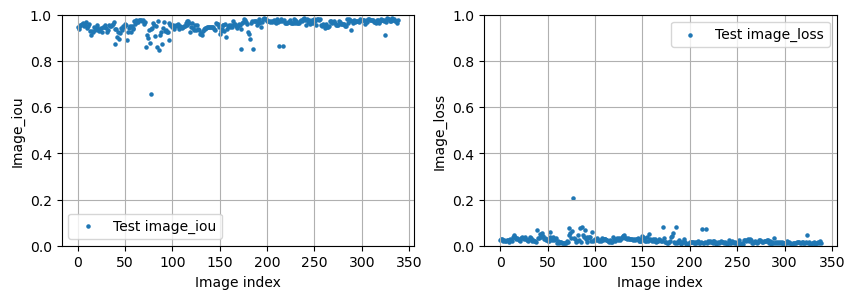

In [ ]:
pth = os.path.join(paths['log_path'], 'test', 'metrics.csv')
display_utils.plot_losses(pth, ['image_iou', 'image_loss'], test = True)

### Generate marked validation images
We will begin by generating the predicted masks on the validation dataset, and save them to disk in `train_data_root\infer\NAME`.
Also, we will display a few images.

In [19]:
time = True # should we time this

save_pth = os.path.join(paths['train_data_root'], 'infer', config['NAME'])
timings = infer_set(model, device, save_pth, dataset=valid_dl.dataset, save=False, to_print=None, time = time, all = True)

# save timings
if time:
    output_file = os.path.join(test_csv_logger.log_dir,'timing.csv')
    os.makedirs(test_csv_logger.log_dir, exist_ok=True)
    with open(output_file, 'w') as f:
        f.write('valid_dataset_v2'+'\n')
        timings.tofile(f, sep='\n', format='%f')

### Out-of-sample Inference
For qualiative evaluation we will generate and display images from out-of-dataset.

First we need to load the inference dataset `infer_dataset`:

In [ ]:
# build dataset
infer_dataset = SegmentationInferenceDataset(paths['inference_data_root'], transform=data_transforms['infer'], is_stereo=True)

Generate the masks:

In [18]:
time = False # select
save_pth = os.path.join(paths['inference_save_path'])
timings = infer_set(model, device, save_pth, dataset=infer_dataset, save=True, to_print=10, time = time, all=True)

# save timings
if time:
    output_file = os.path.join(test_csv_logger.log_dir,'timing.csv')
    os.makedirs(test_csv_logger.log_dir, exist_ok=True)
    with open(output_file, 'w') as f:
        f.write('inference_dataset'+'\n')
        timings.tofile(f, sep='\n', format='%f')

NameError: name 'infer_dataset' is not defined